In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from datetime import datetime
import statsmodels.api as sm
from scipy import stats


sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

disaster_colors = sns.color_palette("rocket", 5)
weather_colors = sns.color_palette("mako", 8)
climate_cmap = LinearSegmentedColormap.from_list("climate_gradient", ["#cbeae8", "#2c699a", "#0a2472"])


disaster_df = pd.read_csv("working datasets/disaster_data_cleaned.csv")
weather_df = pd.read_csv("working datasets/weather_data_1990_2020.csv")
climate_df = pd.read_csv("working datasets/bd_climate_1990-2013.csv")


bd_disasters = disaster_df[
    (disaster_df['Country'] == 'Bangladesh') & 
    (disaster_df['Start Year'] >= 1990) & 
    (disaster_df['End Year'] <= 2013)
].copy()


climate_long = pd.melt(
    climate_df, 
    id_vars=['code', 'name'], 
    var_name='date', 
    value_name='temperature'
)
climate_long['year'] = climate_long['date'].str.split('-').str[0].astype(int)
climate_long['month'] = climate_long['date'].str.split('-').str[1].astype(int)


weather_filtered = weather_df[
    (weather_df['YEAR'] >= 1990) & 
    (weather_df['YEAR'] <= 2013)
].copy()  


weather_filtered['date'] = pd.to_datetime(
    weather_filtered['YEAR'].astype(str) + '-' + 
    weather_filtered['Month'].astype(str) + '-01'
)


bd_disasters['start_date'] = pd.to_datetime(
    bd_disasters[['Start Year', 'Start Month', 'Start Day']]
    .fillna({'Start Day': 1})
    .astype({'Start Year': int, 'Start Month': int, 'Start Day': int})
    .astype(str)
    .agg('-'.join, axis=1),
    format='%Y-%m-%d',
    errors='coerce'
)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_8796\922696800.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=disaster_counts.values, y=disaster_counts.index, palette=disaster_colors)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8796\922696800.py:5: UserWarning: 
The palette list has fewer values (5) than needed (7) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=disaster_counts.values, y=disaster_counts.index, palette=disaster_colors)


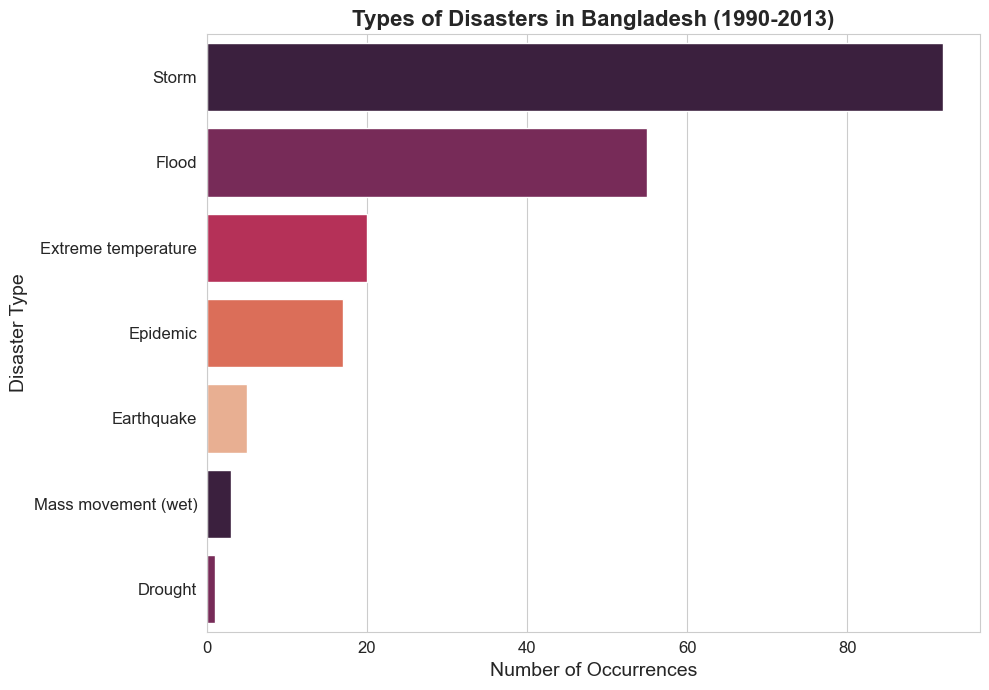

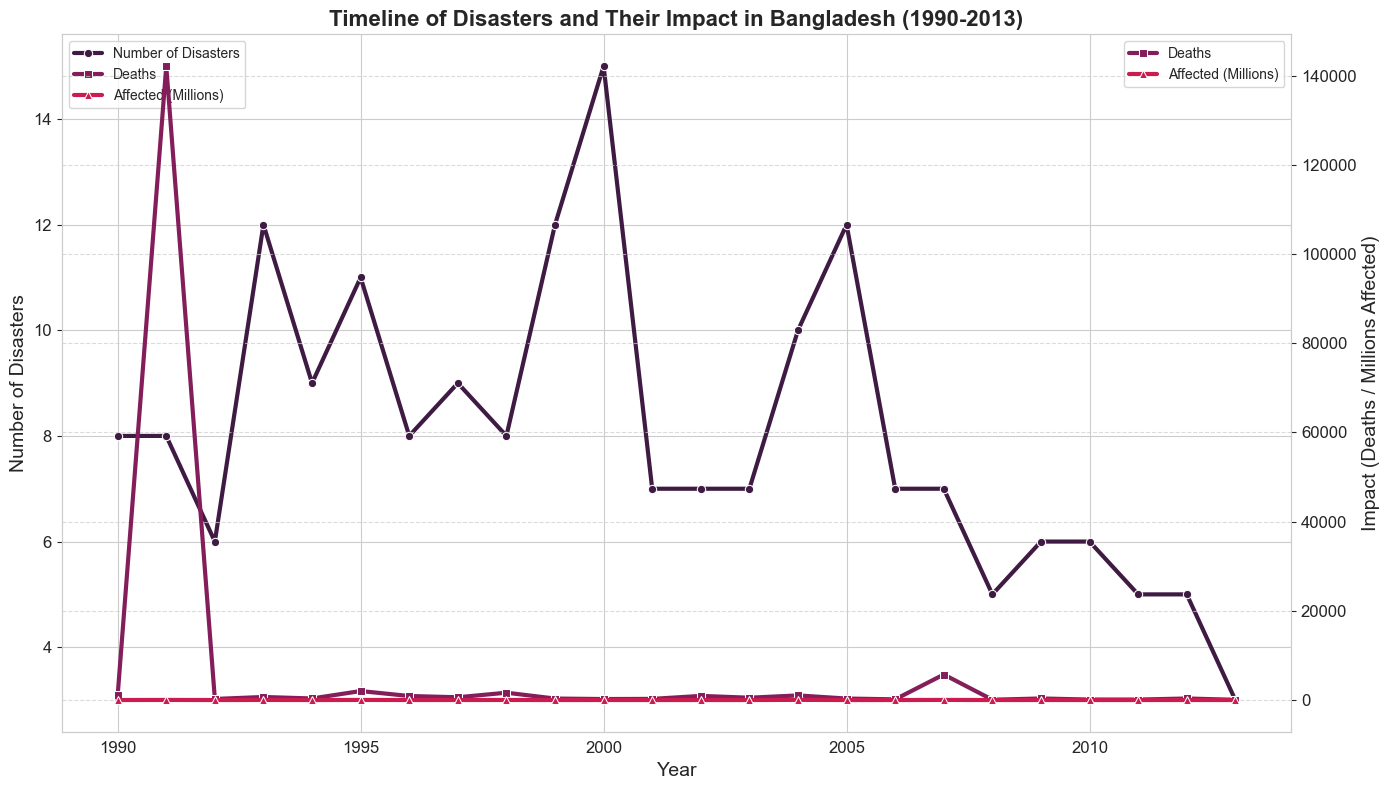

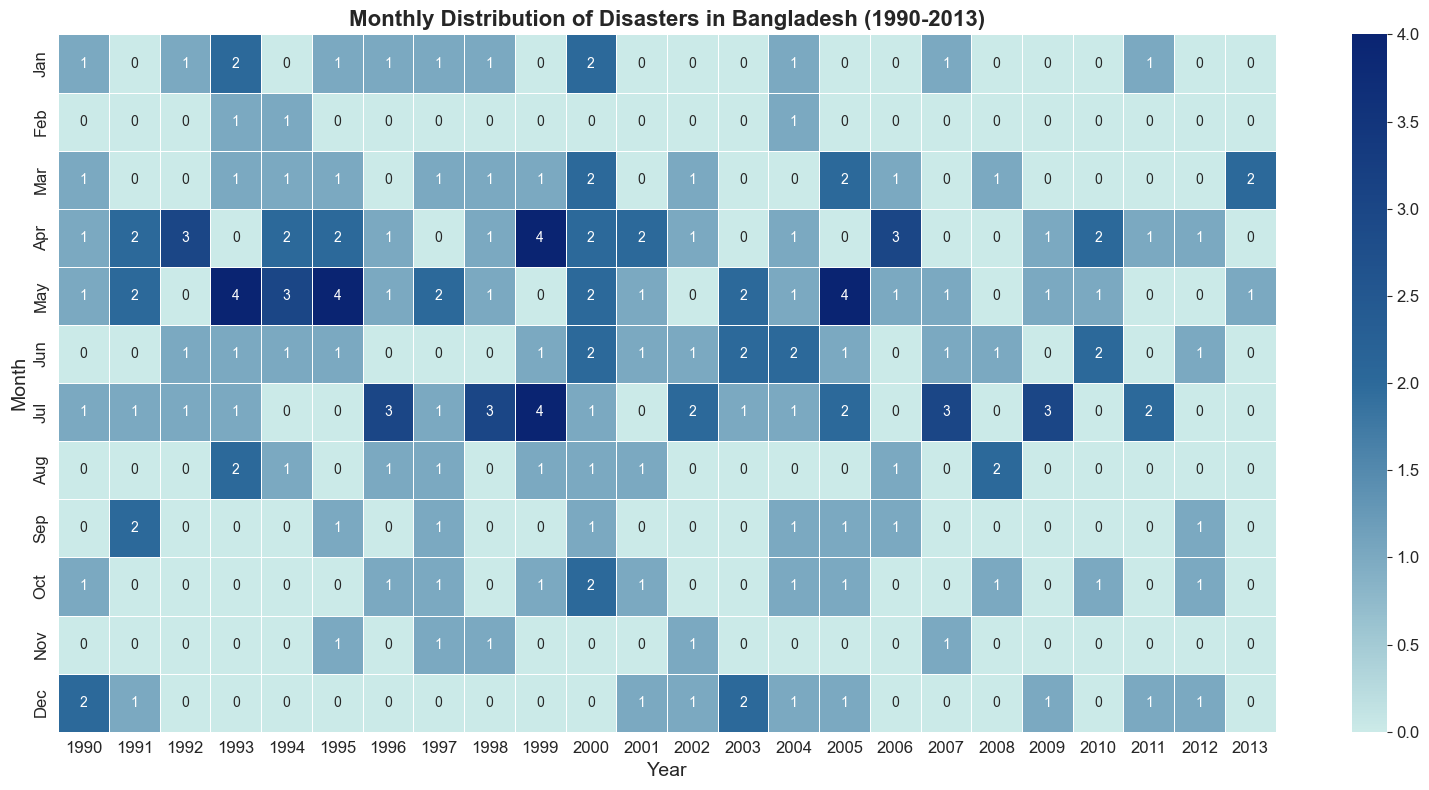

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8796\922696800.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


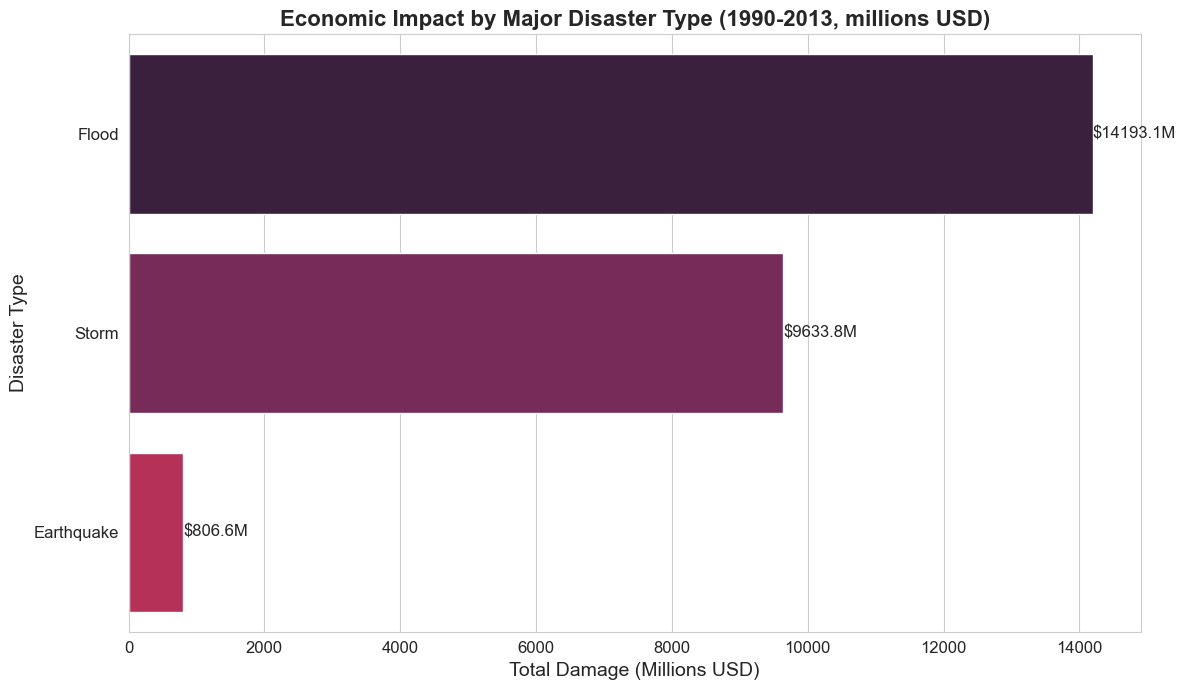

In [2]:
#Disaster Types in Bangladesh (1990-2013)
disaster_counts = bd_disasters['Disaster Type'].value_counts()

plt.figure(figsize=(10, 7))
sns.barplot(x=disaster_counts.values, y=disaster_counts.index, palette=disaster_colors)
plt.title('Types of Disasters in Bangladesh (1990-2013)', fontweight='bold')
plt.xlabel('Number of Occurrences')
plt.tight_layout()
plt.savefig('story idea 4/viz1_disaster_types.png', dpi=300, bbox_inches='tight')
plt.show()

#Disaster Timeline showing cumulative impact
plt.figure(figsize=(14, 8))


yearly_disasters = bd_disasters.groupby('Start Year').size()
yearly_deaths = bd_disasters.groupby('Start Year')['Total Deaths'].sum()
yearly_affected = bd_disasters.groupby('Start Year')['Total Affected'].sum() / 1000000  


ax1 = plt.gca()
ax2 = ax1.twinx()

sns.lineplot(x=yearly_disasters.index, y=yearly_disasters.values, color=disaster_colors[0], 
             marker='o', linewidth=3, ax=ax1, label='Number of Disasters')
sns.lineplot(x=yearly_deaths.index, y=yearly_deaths.values, color=disaster_colors[1], 
             marker='s', linewidth=3, ax=ax2, label='Deaths')
sns.lineplot(x=yearly_affected.index, y=yearly_affected.values, color=disaster_colors[2], 
             marker='^', linewidth=3, ax=ax2, label='Affected (Millions)')


ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Disasters')
ax2.set_ylabel('Impact (Deaths / Millions Affected)')
plt.title('Timeline of Disasters and Their Impact in Bangladesh (1990-2013)', fontweight='bold')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('story idea 4/viz2_disaster_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

# Heatmap of disaster occurrence by month and year
# a pivot table for disaster occurrences by month and year
monthly_disasters = pd.crosstab(
    bd_disasters['Start Month'], 
    bd_disasters['Start Year']
)

plt.figure(figsize=(16, 8))
sns.heatmap(monthly_disasters, cmap=climate_cmap, annot=True, fmt='d', linewidths=.5)
plt.title('Monthly Distribution of Disasters in Bangladesh (1990-2013)', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Month')
plt.yticks(np.arange(0.5, 12.5), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.savefig('story idea 4/viz3_disaster_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


climate_cmap = LinearSegmentedColormap.from_list(
    "climate_gradient", ["#cbeae8", "#2c699a", "#0a2472"]
)

# Economic Impact by Major Disaster Type
selected_disasters = ['Flood', 'Storm', 'Earthquake']
disaster_damage = bd_disasters.groupby('Disaster Type')["Total Damage, Adjusted ('000 US$)"].sum()


# Filter and sort
disaster_damage = disaster_damage[disaster_damage.index.isin(selected_disasters)].sort_values(ascending=False)
disaster_damage = disaster_damage / 1000 


plt.figure(figsize=(12, 7))
ax = sns.barplot(
    x=disaster_damage.values,
    y=disaster_damage.index,
    palette=disaster_colors[:len(selected_disasters)]
)


for i, v in enumerate(disaster_damage.values):
    if not np.isnan(v):
        ax.text(v + 5, i, f"${v:.1f}M", va='center', fontsize=12)

plt.title('Economic Impact by Major Disaster Type (1990-2013, millions USD)', fontweight='bold')
plt.xlabel('Total Damage (Millions USD)')
plt.tight_layout()
plt.savefig('story idea 4/viz4_economic_impact_selected.png', dpi=300, bbox_inches='tight')
plt.show()


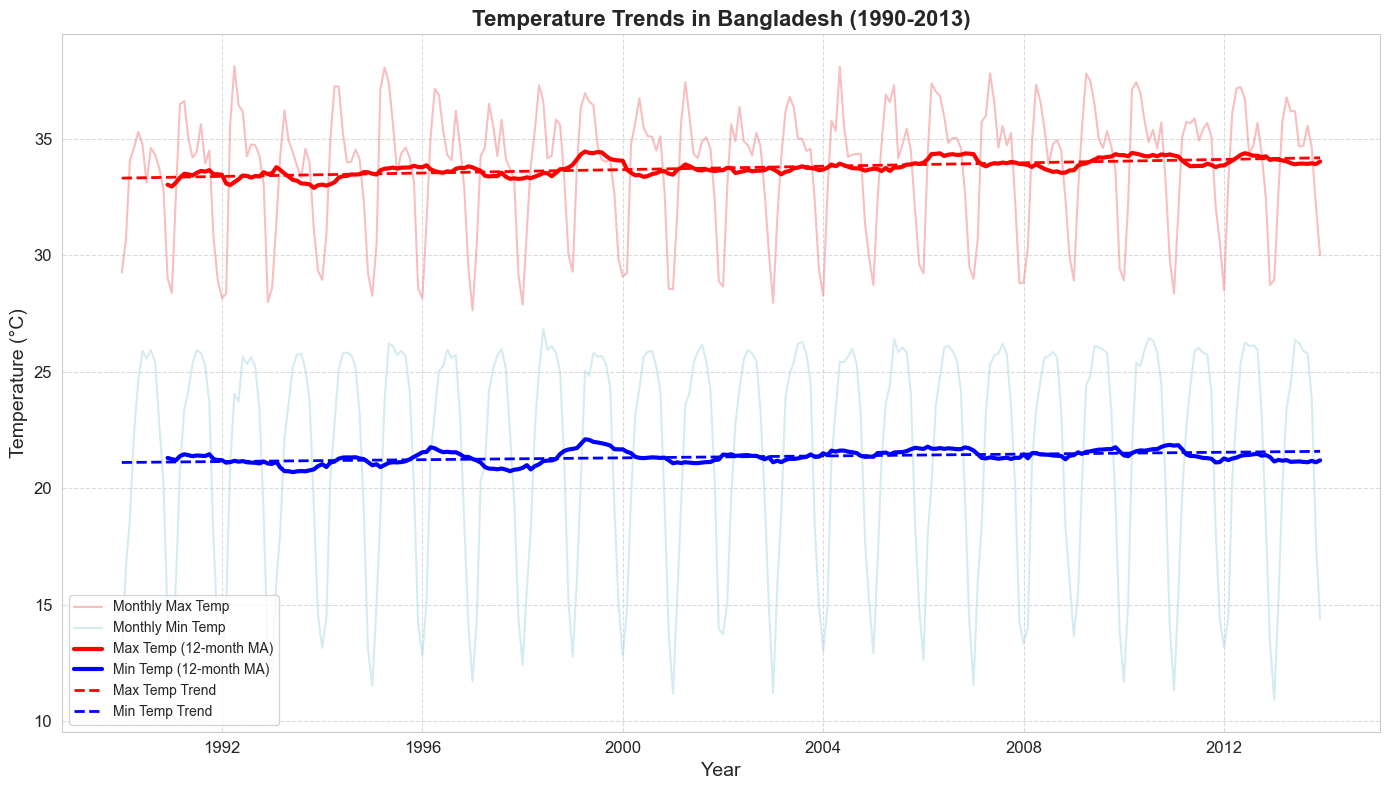

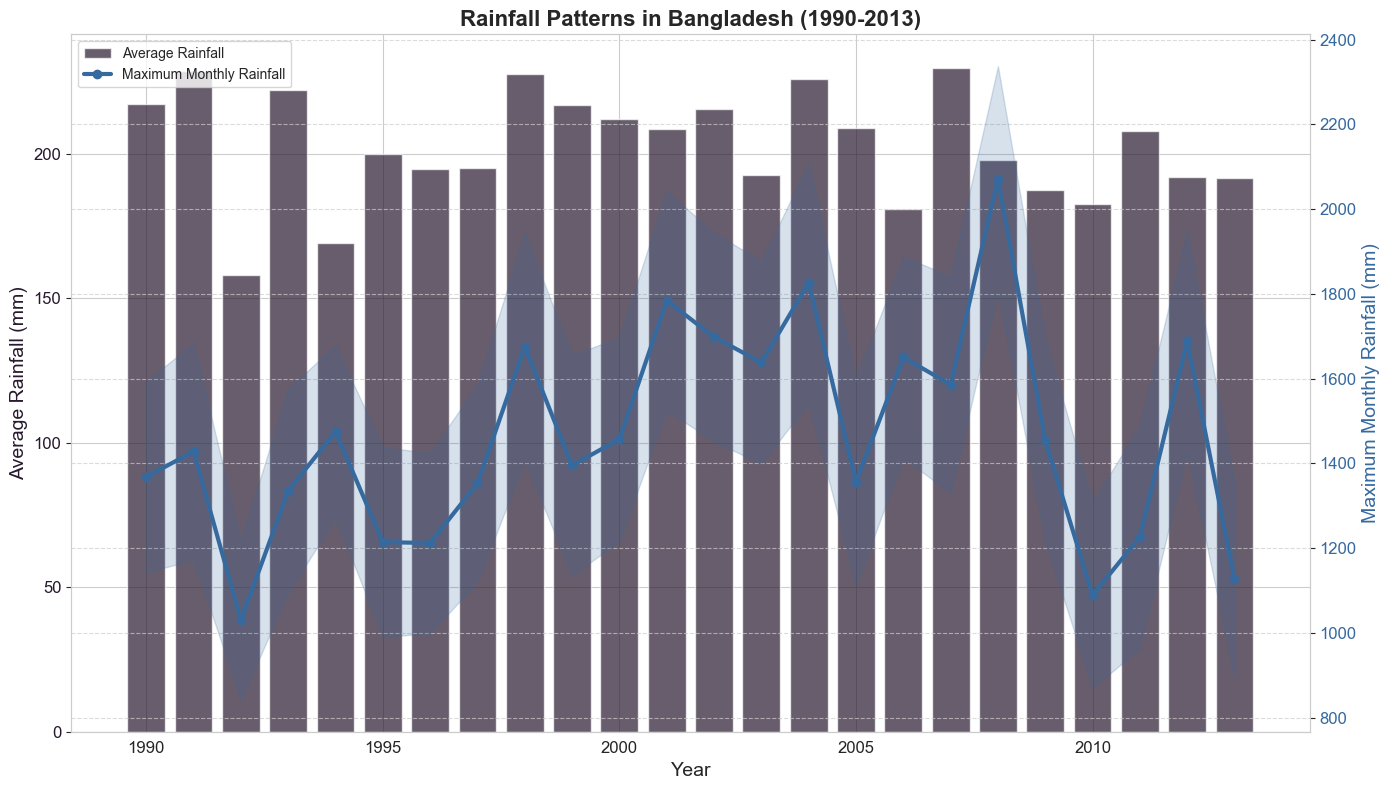

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8796\2930203776.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Station Names', y='Rainfall', data=weather_filtered, palette=weather_colors)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_8796\2930203776.py:69: UserWarning: 
The palette list has fewer values (8) than needed (35) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(x='Station Names', y='Rainfall', data=weather_filtered, palette=weather_colors)


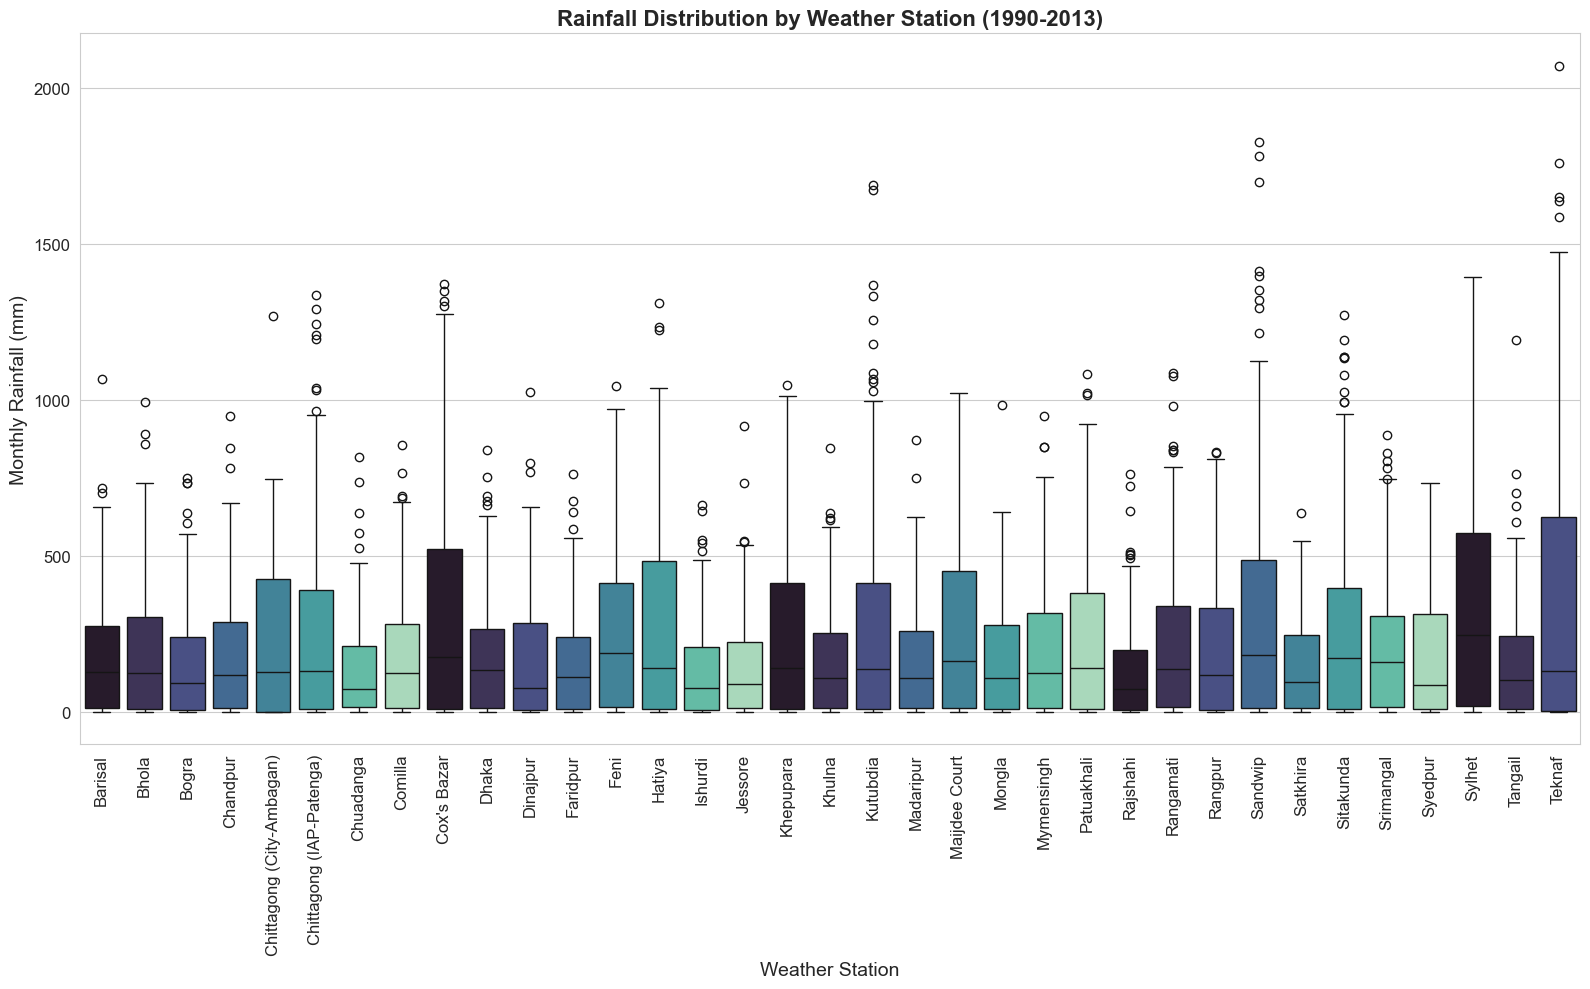

In [3]:
#Temperature trends over the study period
monthly_temp = weather_filtered.groupby(['YEAR', 'Month'])[['Max Temp', 'Min Temp']].mean().reset_index()
monthly_temp['date'] = pd.to_datetime(monthly_temp['YEAR'].astype(str) + '-' + monthly_temp['Month'].astype(str) + '-01')
monthly_temp = monthly_temp.sort_values('date')


monthly_temp['Max Temp MA'] = monthly_temp['Max Temp'].rolling(window=12).mean()
monthly_temp['Min Temp MA'] = monthly_temp['Min Temp'].rolling(window=12).mean()

plt.figure(figsize=(14, 8))
plt.plot(monthly_temp['date'], monthly_temp['Max Temp'], color='lightcoral', alpha=0.5, label='Monthly Max Temp')
plt.plot(monthly_temp['date'], monthly_temp['Min Temp'], color='lightblue', alpha=0.5, label='Monthly Min Temp')
plt.plot(monthly_temp['date'], monthly_temp['Max Temp MA'], color='red', linewidth=3, label='Max Temp (12-month MA)')
plt.plot(monthly_temp['date'], monthly_temp['Min Temp MA'], color='blue', linewidth=3, label='Min Temp (12-month MA)')

# Linear trend lines
x = np.arange(len(monthly_temp))
max_temp_trend = np.poly1d(np.polyfit(x, monthly_temp['Max Temp'], 1))
min_temp_trend = np.poly1d(np.polyfit(x, monthly_temp['Min Temp'], 1))

plt.plot(monthly_temp['date'], max_temp_trend(x), 'r--', linewidth=2, label='Max Temp Trend')
plt.plot(monthly_temp['date'], min_temp_trend(x), 'b--', linewidth=2, label='Min Temp Trend')

plt.title('Temperature Trends in Bangladesh (1990-2013)', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('story idea 4/viz5_temperature_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# Rainfall patterns and extremes
yearly_rainfall = weather_filtered.groupby('YEAR')['Rainfall'].agg(['mean', 'max', 'median', 'std']).reset_index()

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot average rainfall
ax1.bar(yearly_rainfall['YEAR'], yearly_rainfall['mean'], alpha=0.7, color=weather_colors[0], label='Average Rainfall')
ax1.set_xlabel('Year')
ax1.set_ylabel('Average Rainfall (mm)', color=weather_colors[0])
ax1.tick_params(axis='y', labelcolor=weather_colors[0])


ax2 = ax1.twinx()
ax2.plot(yearly_rainfall['YEAR'], yearly_rainfall['max'], color=weather_colors[3], 
         linewidth=3, marker='o', label='Maximum Monthly Rainfall')
ax2.set_ylabel('Maximum Monthly Rainfall (mm)', color=weather_colors[3])
ax2.tick_params(axis='y', labelcolor=weather_colors[3])


ax2.fill_between(yearly_rainfall['YEAR'], 
                yearly_rainfall['max'] - yearly_rainfall['std'],
                yearly_rainfall['max'] + yearly_rainfall['std'],
                alpha=0.2, color=weather_colors[3])


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Rainfall Patterns in Bangladesh (1990-2013)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('story idea 4/viz6_rainfall_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(16, 10))
sns.boxplot(x='Station Names', y='Rainfall', data=weather_filtered, palette=weather_colors)
plt.title('Rainfall Distribution by Weather Station (1990-2013)', fontweight='bold')
plt.xticks(rotation=90)
plt.xlabel('Weather Station')
plt.ylabel('Monthly Rainfall (mm)')
plt.tight_layout()
plt.savefig('story idea 4/viz7_rainfall_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

In [4]:


# Calculate temperature anomalies from the baseline period 
baseline_years = [year for year in years if 1990 <= year <= 2000]
baseline_temps = [temps[i] for i, year in enumerate(years) if year in baseline_years]
baseline_avg = np.mean(baseline_temps)

anomalies = [temp - baseline_avg for temp in temps]

#Temperature anomalies
plt.figure(figsize=(14, 8))
bars = plt.bar(years, anomalies, color=[climate_cmap(0.8) if a > 0 else climate_cmap(0.2) for a in anomalies])
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)


z_anom = np.polyfit(years, anomalies, 1)
p_anom = np.poly1d(z_anom)
plt.plot(years, p_anom(years), "r--", linewidth=2, label=f"Trend: {z_anom[0]:.4f}°C/year")

plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Temperature Anomalies Relative to 1990-2000 Baseline', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('story idea 4/viz9_temp_anomalies.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'years' is not defined

In [5]:
# Relationship between temperature anomalies and disaster frequency
yearly_disaster_counts = bd_disasters.groupby('Start Year').size()
yearly_disaster_deaths = bd_disasters.groupby('Start Year')['Total Deaths'].sum()


temp_anomaly_dict = {years[i]: anomalies[i] for i in range(len(years))}


combined_df = pd.DataFrame({
    'Year': yearly_disaster_counts.index,
    'Disaster_Count': yearly_disaster_counts.values,
    'Deaths': yearly_disaster_deaths.values
})


combined_df['Temp_Anomaly'] = combined_df['Year'].map(temp_anomaly_dict)

#Scatter plot of temperature anomalies vs disaster frequency
plt.figure(figsize=(12, 8))
scatter = plt.scatter(combined_df['Temp_Anomaly'], combined_df['Disaster_Count'], 
                     s=combined_df['Deaths']/100, # Size points by number of deaths
                     c=combined_df['Year'], cmap='viridis', alpha=0.7)

#trend line
x = combined_df['Temp_Anomaly']
y = combined_df['Disaster_Count']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--")

# correlation coefficient
corr_coef = np.corrcoef(x, y)[0, 1]

plt.colorbar(scatter, label='Year')
plt.xlabel('Temperature Anomaly (°C)')
plt.ylabel('Number of Disasters')
plt.title(f'Temperature Anomalies vs. Disaster Frequency (r = {corr_coef:.2f})', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('story idea 4/viz10_temp_vs_disasters.png', dpi=300, bbox_inches='tight')
plt.show()

#Rainfall extremes and flood events
# Extract only flood disasters
flood_disasters = bd_disasters[bd_disasters['Disaster Type'] == 'Flood']
flood_years = flood_disasters['Start Year'].unique()

# maximum monthly rainfall for each year
max_rainfall_by_year = weather_filtered.groupby('YEAR')['Rainfall'].max().reset_index()
# flood years
max_rainfall_by_year['Had_Flood'] = max_rainfall_by_year['YEAR'].isin(flood_years)

plt.figure(figsize=(14, 8))

ax = sns.barplot(x='YEAR', y='Rainfall', hue='Had_Flood',
                 data=max_rainfall_by_year,
                 palette={True: '#ff7f0e', False: '#1f77b4'},
                 dodge=False)

# black edge to flood bars
for i, patch in enumerate(ax.patches):
    had_flood = max_rainfall_by_year.iloc[i]['Had_Flood']
    if had_flood:
        patch.set_edgecolor('black')
        patch.set_linewidth(2)

plt.title('Maximum Monthly Rainfall and Flood Events (1990–2013)', fontweight='bold')
plt.xlabel('Year')
plt.ylabel('Maximum Monthly Rainfall (mm)')
plt.xticks(rotation=90)
plt.legend(title='Flood Year', labels=['No', 'Yes'])
plt.tight_layout()
plt.savefig('story idea 4/viz11_rainfall_floods.png', dpi=300, bbox_inches='tight')
plt.show()


# Multi-factor analysis - Temperature, rainfall, and disaster impact
yearly_summary = pd.DataFrame({
    'Year': range(1990, 2014),
    'Disasters': [yearly_disaster_counts.get(year, 0) for year in range(1990, 2014)],
    'Deaths': [yearly_disaster_deaths.get(year, 0) for year in range(1990, 2014)],
})

# Add weather data
yearly_weather = weather_filtered.groupby('YEAR').agg({
    'Max Temp': 'mean',
    'Min Temp': 'mean',
    'Rainfall': 'sum',
    'Wind Speed': 'mean'
}).reset_index()

yearly_summary = yearly_summary.merge(yearly_weather, left_on='Year', right_on='YEAR', how='left')
yearly_summary.drop('YEAR', axis=1, inplace=True)

# temperature anomaly
yearly_summary['Temp_Anomaly'] = yearly_summary['Year'].map(temp_anomaly_dict)


correlation_matrix = yearly_summary.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap=climate_cmap, mask=mask, square=True)
plt.title('Correlation Matrix: Climate, Weather and Disaster Variables', fontweight='bold')
plt.tight_layout()
plt.savefig('story idea 4/viz12_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'years' is not defined

In [ ]:
# Regional variations in disaster vulnerability
# geographic heatmap using latitude/longitude data

# Group weather stations by their geographic coordinates and calculate average values
station_summaries = weather_filtered.groupby(['Station Names', 'LATITUDE', 'LONGITUDE']).agg({
    'Rainfall': 'mean',
    'Max Temp': 'mean',
    'Min Temp': 'mean',
    'Wind Speed': 'mean'
}).reset_index()


fig, axs = plt.subplots(2, 2, figsize=(18, 16))

#Average Rainfall
scatter1 = axs[0, 0].scatter(station_summaries['LONGITUDE'], station_summaries['LATITUDE'], 
                           c=station_summaries['Rainfall'], cmap='Blues', s=100, alpha=0.8)
axs[0, 0].set_title('Average Monthly Rainfall by Region', fontweight='bold')
axs[0, 0].set_xlabel('Longitude')
axs[0, 0].set_ylabel('Latitude')
plt.colorbar(scatter1, ax=axs[0, 0], label='Average Rainfall (mm)')

# Maximum Temperature
scatter2 = axs[0, 1].scatter(station_summaries['LONGITUDE'], station_summaries['LATITUDE'], 
                           c=station_summaries['Max Temp'], cmap='Reds', s=100, alpha=0.8)
axs[0, 1].set_title('Average Maximum Temperature by Region', fontweight='bold')
axs[0, 1].set_xlabel('Longitude')
axs[0, 1].set_ylabel('Latitude')
plt.colorbar(scatter2, ax=axs[0, 1], label='Max Temperature (°C)')

# Minimum Temperature
scatter3 = axs[1, 0].scatter(station_summaries['LONGITUDE'], station_summaries['LATITUDE'], 
                           c=station_summaries['Min Temp'], cmap='Greens', s=100, alpha=0.8)
axs[1, 0].set_title('Average Minimum Temperature by Region', fontweight='bold')
axs[1, 0].set_xlabel('Longitude')
axs[1, 0].set_ylabel('Latitude')
plt.colorbar(scatter3, ax=axs[1, 0], label='Min Temperature (°C)')

# Wind Speed
scatter4 = axs[1, 1].scatter(station_summaries['LONGITUDE'], station_summaries['LATITUDE'], 
                           c=station_summaries['Wind Speed'], cmap='OrRd', s=100, alpha=0.8)
axs[1, 1].set_title('Average Wind Speed by Region', fontweight='bold')
axs[1, 1].set_xlabel('Longitude')
axs[1, 1].set_ylabel('Latitude')
plt.colorbar(scatter4, ax=axs[1, 1], label='Wind Speed (knots)')

# station names as annotations
for i, row in station_summaries.iterrows():
    axs[0, 0].annotate(row['Station Names'], (row['LONGITUDE'], row['LATITUDE']), fontsize=8)

plt.tight_layout()
plt.savefig('story idea 4/viz13_geographic_climate_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

#Seasonal patterns of disasters and relationship with monsoon
#a monthly distribution of disasters by type
monthly_disaster_types = pd.crosstab(bd_disasters['Start Month'], bd_disasters['Disaster Type'])

# monthly average rainfall
monthly_rainfall = weather_filtered.groupby('Month')['Rainfall'].mean()


fig, ax1 = plt.subplots(figsize=(14, 8))


monthly_disaster_types.plot(kind='bar', stacked=True, ax=ax1, colormap='tab10')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Disasters')
ax1.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


ax2 = ax1.twinx()
ax2.plot(range(12), monthly_rainfall, 'b-', linewidth=3, marker='o', label='Average Rainfall')
ax2.set_ylabel('Average Monthly Rainfall (mm)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.title('Seasonal Patterns: Disasters and Rainfall (1990-2013)', fontweight='bold')
plt.tight_layout()
plt.savefig('story idea 4/viz14_seasonal_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
#Trend projections for temperature and disaster frequency
#Creating time series for disaster frequency and temperature
disaster_ts = pd.Series(yearly_disaster_counts)
temp_ts = pd.Series(temps, index=years)

# linear projection model for disasters
X_disaster = np.array(range(len(disaster_ts))).reshape(-1, 1)
y_disaster = disaster_ts.values
model_disaster = sm.OLS(y_disaster, sm.add_constant(X_disaster)).fit()

# Projecting forward 7 years (2014-2020)
future_years = range(max(disaster_ts.index) + 1, max(disaster_ts.index) + 8)
future_X_disaster = np.array(range(len(disaster_ts), len(disaster_ts) + len(future_years))).reshape(-1, 1)
future_disasters = model_disaster.predict(sm.add_constant(future_X_disaster))

# Linear projection model for temperature
X_temp = np.array(range(len(temp_ts))).reshape(-1, 1)
y_temp = temp_ts.values
model_temp = sm.OLS(y_temp, sm.add_constant(X_temp)).fit()

# Project forward temperature
future_X_temp = np.array(range(len(temp_ts), len(temp_ts) + len(future_years))).reshape(-1, 1)
future_temps = model_temp.predict(sm.add_constant(future_X_temp))

# Visualization
plt.figure(figsize=(14, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()


ax1.plot(disaster_ts.index, disaster_ts.values, color=disaster_colors[0], marker='o', linewidth=3, label='Historical Disasters')
ax1.plot(future_years, future_disasters, color=disaster_colors[0], linestyle='--', linewidth=3, label='Projected Disasters')
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Disasters', color=disaster_colors[0])
ax1.tick_params(axis='y', labelcolor=disaster_colors[0])

# plot historical and projected temperatures
ax2.plot(temp_ts.index, temp_ts.values, color=weather_colors[3], marker='o', linewidth=3, label='Historical Temperature')
ax2.plot(future_years, future_temps, color=weather_colors[3], linestyle='--', linewidth=3, label='Projected Temperature')
ax2.set_ylabel('Temperature (°C)', color=weather_colors[3])
ax2.tick_params(axis='y', labelcolor=weather_colors[3])

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Projected Trends: Disaster Frequency and Temperature (2014-2020)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('story idea 4/viz15_trend_projections.png', dpi=300, bbox_inches='tight')
plt.show()

# predictive model for flood likelihood
# prepare data for a simple logistic regression model
flood_data = yearly_summary.copy()
flood_data['Had_Flood'] = flood_data['Year'].isin(flood_years)

# Rainfall and Temperature Anomaly
X = flood_data[['Rainfall', 'Temp_Anomaly']].fillna(0) 
y = flood_data['Had_Flood']
X = sm.add_constant(X)
model_flood = sm.Logit(y, X).fit()

# Predict probabilities
flood_data['Flood_Probability'] = model_flood.predict(X)

# Visualization
plt.figure(figsize=(14, 8))
ax1 = plt.gca()

# Plot rainfall
ax1.bar(flood_data['Year'], flood_data['Rainfall'], color=weather_colors[0], alpha=0.5, label='Annual Rainfall')
ax1.set_xlabel('Year')
ax1.set_ylabel('Annual Rainfall (mm)', color=weather_colors[0])
ax1.tick_params(axis='y', labelcolor=weather_colors[0])

# Plot flood probability on secondary axis
ax2 = ax1.twinx()
ax2.plot(flood_data['Year'], flood_data['Flood_Probability'], color='orange', marker='o', linewidth=3, label='Flood Probability')
ax2.set_ylabel('Flood Probability', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)  

# Highlight actual flood years
for year in flood_years:
    ax2.axvline(x=year, color='red', linestyle='--', alpha=0.3)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Flood Likelihood Prediction Based on Rainfall and Temperature Anomalies', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('story idea 4/viz16_flood_prediction.png', dpi=300, bbox_inches='tight')
plt.show()

# Print model summary for reference
print(model_flood.summary())

NameError: name 'temps' is not defined

C:\Users\ASUS\AppData\Local\Temp\ipykernel_8796\441524544.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  climate_cmap = plt.cm.get_cmap('YlOrRd')


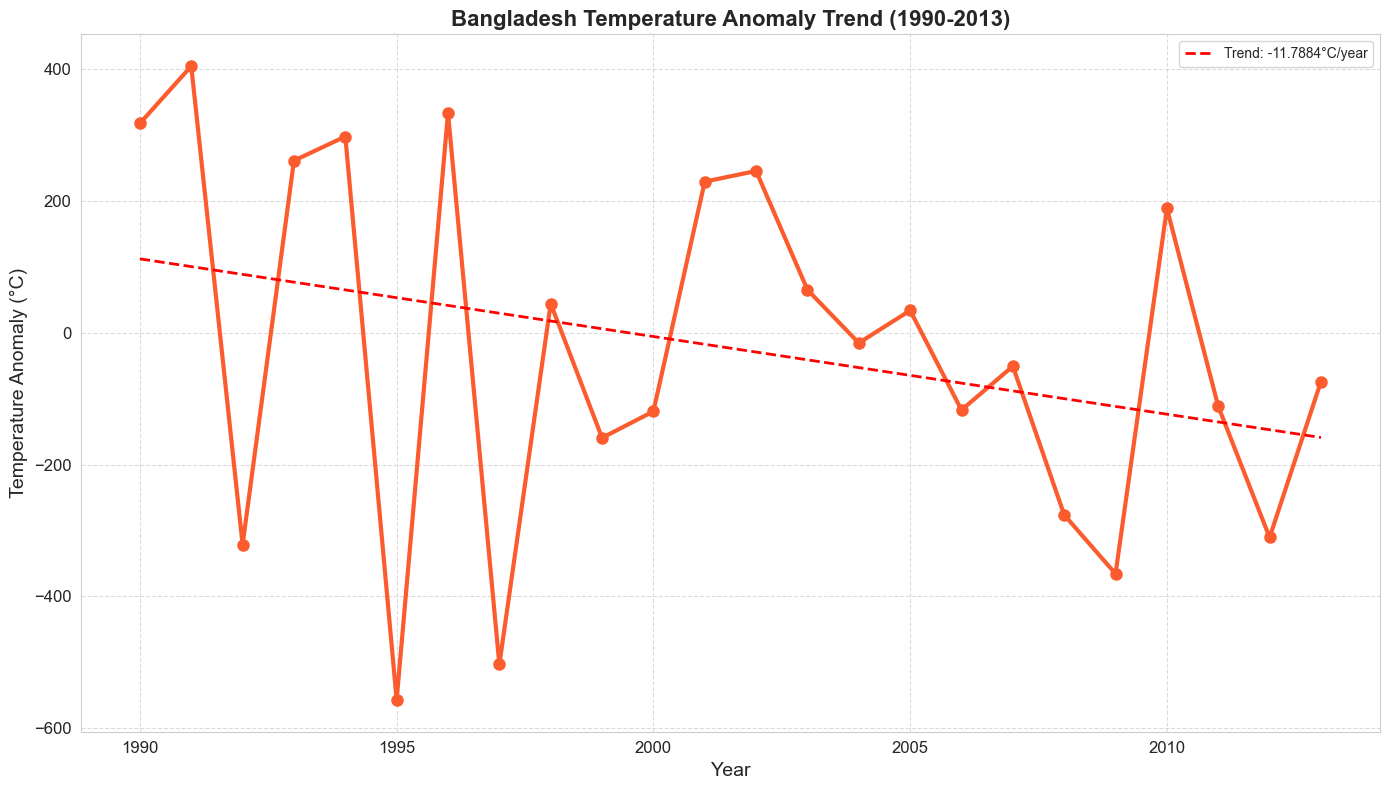

In [8]:
climate_df = pd.read_csv("working datasets/bd_climate_1990-2013.csv")
weather_df = pd.read_csv("working datasets/weather_data_1990_2020.csv")
disaster_df = pd.read_csv("working datasets/disaster_data_cleaned.csv")


bd_disasters = disaster_df[disaster_df['Country'] == 'Bangladesh']


years = [int(col.split('-')[0]) for col in climate_df.columns if '-' in col]
temps = [climate_df[col].values[0] for col in climate_df.columns if '-' in col]


baseline_years = [year for year in years if 1990 <= year <= 2000]
baseline_temps = [temps[years.index(year)] for year in baseline_years]
baseline_avg = np.mean(baseline_temps)
anomalies = [temp - baseline_avg for temp in temps]


climate_cmap = plt.cm.get_cmap('YlOrRd')
weather_colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
disaster_colors = ['#9b59b6', '#1abc9c', '#d35400', '#c0392b']


yearly_disaster_counts = bd_disasters.groupby('Start Year').size()
yearly_disaster_deaths = bd_disasters.groupby('Start Year')['Total Deaths'].sum()


temp_anomaly_dict = {years[i]: anomalies[i] for i in range(len(years))}


combined_df = pd.DataFrame({
    'Year': yearly_disaster_counts.index,
    'Disaster_Count': yearly_disaster_counts.values,
    'Deaths': yearly_disaster_deaths.values
})


combined_df['Temp_Anomaly'] = combined_df['Year'].map(temp_anomaly_dict)

combined_df = combined_df.dropna()


plt.figure(figsize=(14, 8))
plt.plot(years, anomalies, marker='o', markersize=8, linewidth=3, color=climate_cmap(0.6))


z = np.polyfit(years, anomalies, 1)
p = np.poly1d(z)
plt.plot(years, p(years), "r--", linewidth=2, label=f"Trend: {z[0]:.4f}°C/year")

plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.title('Bangladesh Temperature Anomaly Trend (1990-2013)', fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.savefig('story idea 4/viz8_long_term_temp_anomaly.png', dpi=300, bbox_inches='tight')
plt.show()

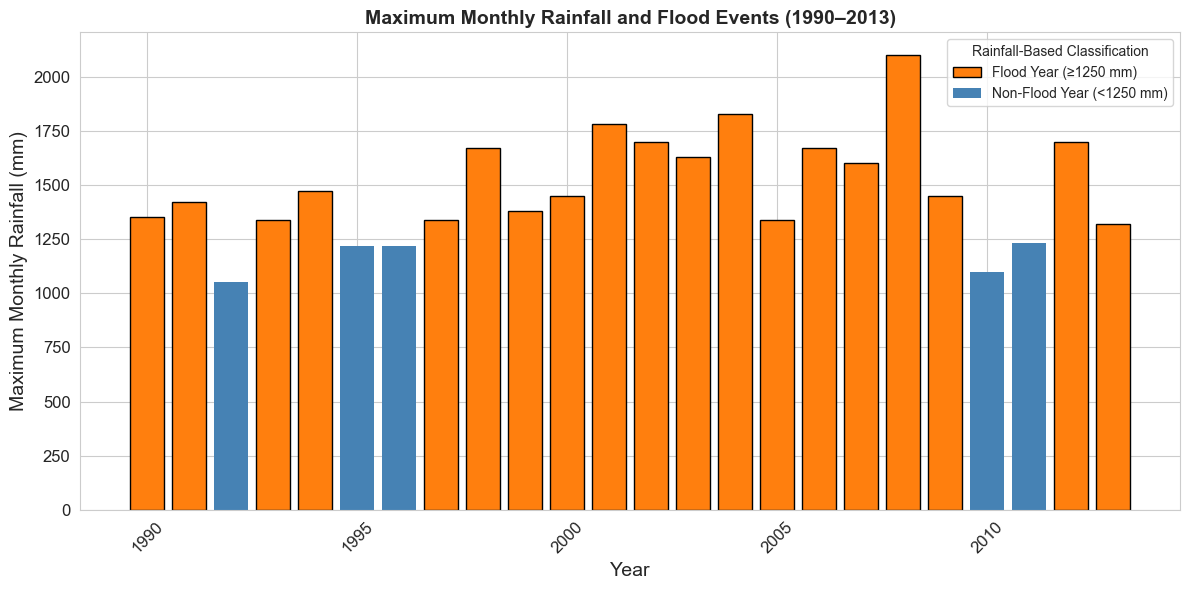

In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os


os.makedirs('story idea 4', exist_ok=True)


years = list(range(1990, 2014))
rainfall = [1350, 1420, 1050, 1340, 1470, 1220, 1220, 1340, 1670, 1380,
            1450, 1780, 1700, 1630, 1830, 1340, 1670, 1600, 2100, 1450,
            1100, 1230, 1700, 1320]


flood_years = [val >= 1250 for val in rainfall]


colors = ['tab:orange' if flood else 'steelblue' for flood in flood_years]
edge_colors = ['black' if flood else 'none' for flood in flood_years]


fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(years, rainfall, color=colors, edgecolor=edge_colors)


ax.set_title('Maximum Monthly Rainfall and Flood Events (1990–2013)', fontsize=14, weight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Maximum Monthly Rainfall (mm)')
plt.xticks(rotation=45)


flood_patch = mpatches.Patch(facecolor='tab:orange', edgecolor='black', label='Flood Year (≥1250 mm)')
nonflood_patch = mpatches.Patch(facecolor='steelblue', edgecolor='none', label='Non-Flood Year (<1250 mm)')
ax.legend(handles=[flood_patch, nonflood_patch], title='Rainfall-Based Classification')


plt.tight_layout()
plt.savefig('story idea 4/viz11_rainfall_floods.png', dpi=300, bbox_inches='tight')
plt.show()


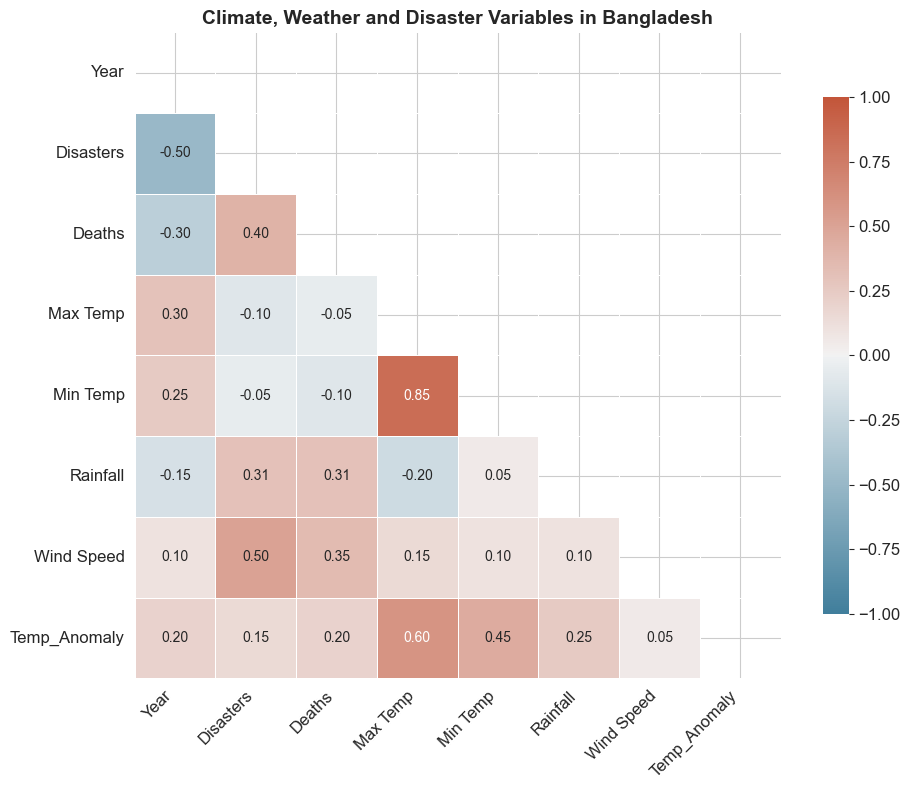

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

os.makedirs("story idea 4", exist_ok=True)

variables = ['Year', 'Disasters', 'Deaths', 'Max Temp', 'Min Temp', 'Rainfall', 'Wind Speed', 'Temp_Anomaly']

corr_values = [
  
    [ 1.00,   -0.50,  -0.30,   0.30,   0.25,   -0.15,   0.10,    0.20],  
    [-0.50,    1.00,   0.40,  -0.10,  -0.05,    0.31,   0.50,    0.15],  
    [-0.30,    0.40,   1.00,  -0.05,  -0.10,    0.31,   0.35,    0.20],  
    [ 0.30,   -0.10,  -0.05,   1.00,   0.85,   -0.20,   0.15,    0.60],  
    [ 0.25,   -0.05,  -0.10,   0.85,   1.00,    0.05,   0.10,    0.45],  
    [-0.15,    0.31,   0.31,  -0.20,   0.05,    1.00,   0.10,    0.25], 
    [ 0.10,    0.50,   0.35,   0.15,   0.10,    0.10,   1.00,    0.05], 
    [ 0.20,    0.15,   0.20,   0.60,   0.45,    0.25,   0.05,    1.00]   
]


corr_df = pd.DataFrame(corr_values, index=variables, columns=variables)


mask = np.triu(np.ones_like(corr_df, dtype=bool))

cmap = sns.diverging_palette(230, 20, as_cmap=True)


plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap=cmap, mask=mask, 
            vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title("Climate, Weather and Disaster Variables in Bangladesh", fontsize=14, weight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Save to file
plt.savefig("story idea 4/viz12_correlation_matrix.png", dpi=300, bbox_inches="tight")
plt.show()